<a href="https://colab.research.google.com/github/dvircohen0/DCGAN-pokemon/blob/main/CGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import print_function
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from torchvision.utils import save_image

dataroot = "/content"
workers = 2
batch_size = 64
image_size = 32
nc = 1
nz = 100
ngf = 64
ndf = 32
num_epochs = 15
lr = 0.0002
beta1 = 0.5
ngpu = 8
n_classes = 10
sample_interval = 400

os.makedirs("images", exist_ok = True)
os.makedirs(dataroot, exist_ok = True)


dataloader = torch.utils.data.DataLoader(dset.FashionMNIST(dataroot,train = True,download = True,
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),transforms.Normalize([0.5], [0.5])]),),
    batch_size = batch_size,shuffle = True,)

dataloaderC = torch.utils.data.DataLoader(dataloader, batch_size = batch_size, shuffle = True, num_workers = workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
image_shape = (nc, image_size, image_size)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(nz + n_classes, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh())
        
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *image_shape)
        return img
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 1),)
        
    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity
    
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

loss = nn.MSELoss()
real_label = 1
fake_label = 0
 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

FloatTensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor


def sample_image(n_row, batches_done):
    z = Variable(FloatTensor(np.random.normal(0,1,(n_row**2,nz))))
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imags = netG(z, labels)
    save_image(gen_imags.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)
    
    
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]
        
        valid = Variable(FloatTensor(batch_size,1).fill_(1.0), requires_grad = False)
        fake = Variable(FloatTensor(batch_size,1).fill_(0.0), requires_grad = False)
        
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        
        #------------------------
        #    Train Generator
        #------------------------
        
        optimizerG.zero_grad()
        z = Variable(FloatTensor(np.random.normal(0,1,(batch_size,nz))))
        gen_labels = Variable(LongTensor(np.random.randint(0,n_classes, batch_size)))
        gen_imgs = netG(z, gen_labels)
        validity = netD(gen_imgs, gen_labels)
        g_loss = loss(validity, valid)
        d_loss.backward()
        optimizerD.step()
        
         #------------------------
        #    Train Discriminator
        #------------------------

        optimizerD.zero_grad()
        validity_real = netD(real_imgs, labels)
        d_real_loss = loss(validity_real, valid)
        validity_fake = netD(gen_imgs.detach(), labels)
        d_fake_loss = loss(validity_fake, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizerD.step()

        print("[Epoch %d/%d][Batch %d/%d][D loss %f][G loss %f]"%
              (epoch, num_epochs, i , len(dataloader), d_loss.item(), g_loss.item()))
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
        

        
 

Streaming output truncated to the last 5000 lines.
[Epoch 9/15][Batch 628/938][D loss 0.073538][G loss 0.036942]
[Epoch 9/15][Batch 629/938][D loss 0.062147][G loss 0.149552]
[Epoch 9/15][Batch 630/938][D loss 0.086843][G loss 0.100698]
[Epoch 9/15][Batch 631/938][D loss 0.085189][G loss 0.038818]
[Epoch 9/15][Batch 632/938][D loss 0.068429][G loss 0.107947]
[Epoch 9/15][Batch 633/938][D loss 0.076363][G loss 0.059604]
[Epoch 9/15][Batch 634/938][D loss 0.085805][G loss 0.126092]
[Epoch 9/15][Batch 635/938][D loss 0.078340][G loss 0.182082]
[Epoch 9/15][Batch 636/938][D loss 0.033181][G loss 0.107801]
[Epoch 9/15][Batch 637/938][D loss 0.081954][G loss 0.060717]
[Epoch 9/15][Batch 638/938][D loss 0.056916][G loss 0.134037]
[Epoch 9/15][Batch 639/938][D loss 0.099082][G loss 0.169286]
[Epoch 9/15][Batch 640/938][D loss 0.058926][G loss 0.084947]
[Epoch 9/15][Batch 641/938][D loss 0.072638][G loss 0.052980]
[Epoch 9/15][Batch 642/938][D loss 0.091843][G loss 0.154820]
[Epoch 9/15][Batch 

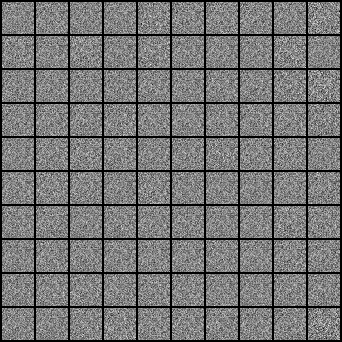

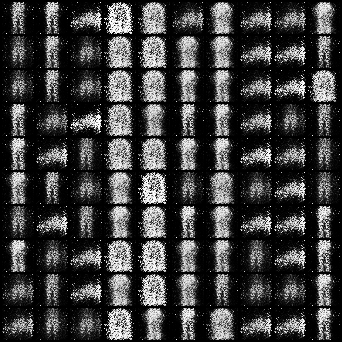

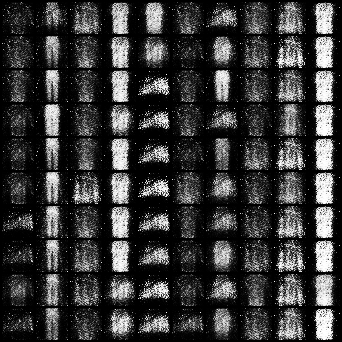

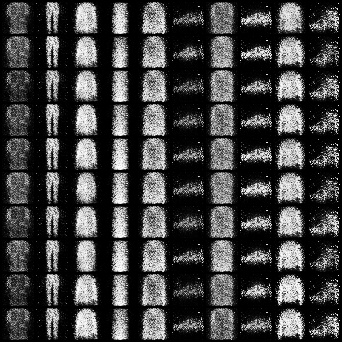

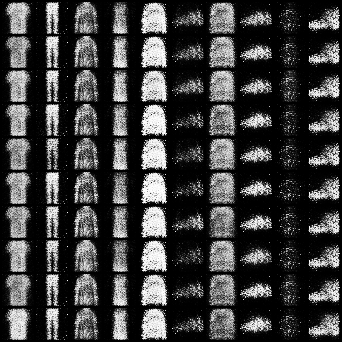

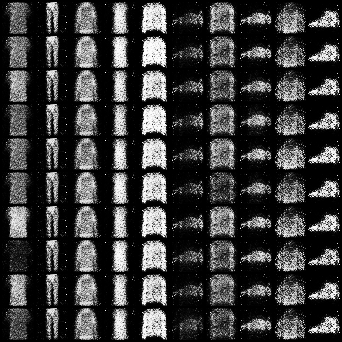

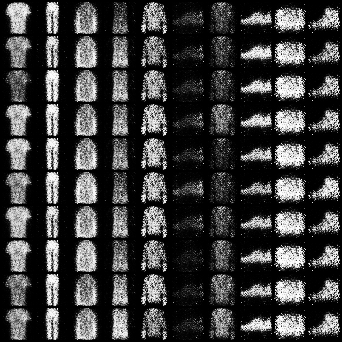

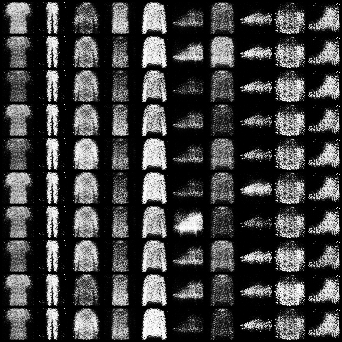

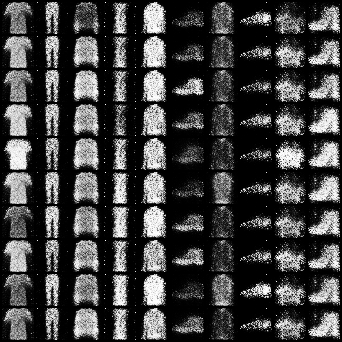

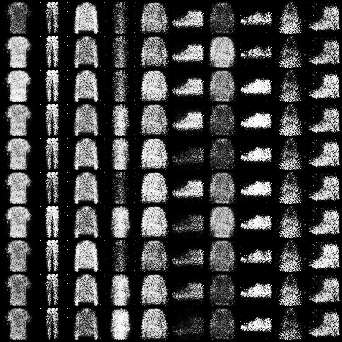

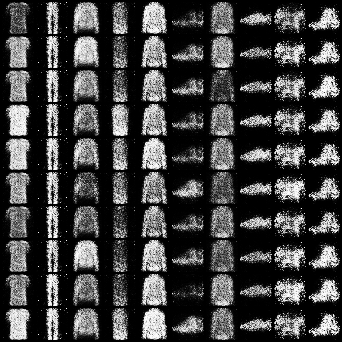

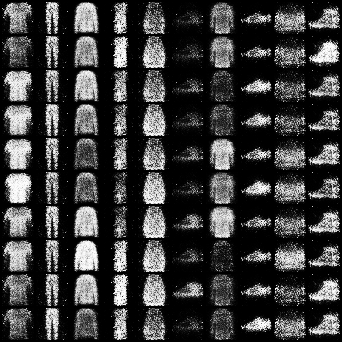

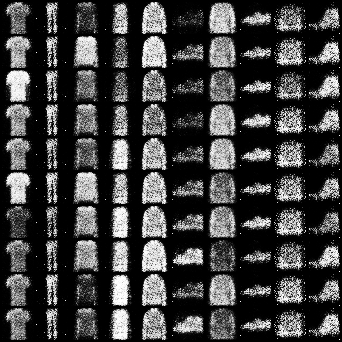

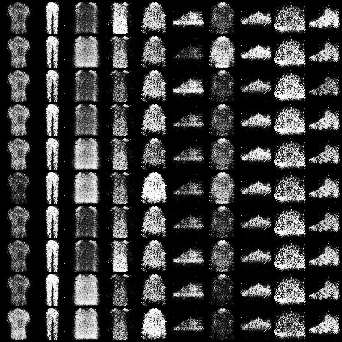

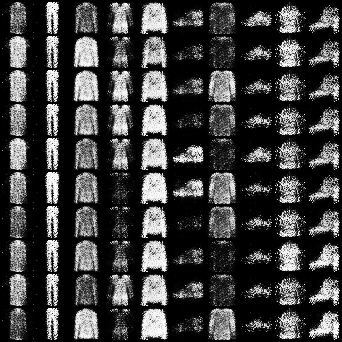

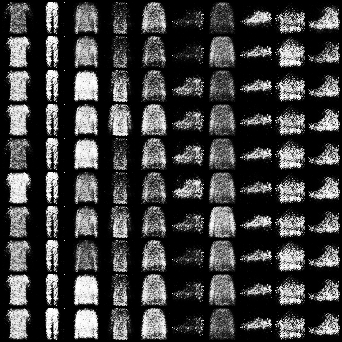

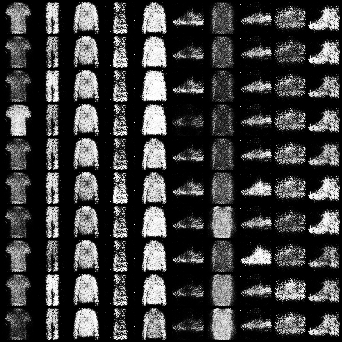

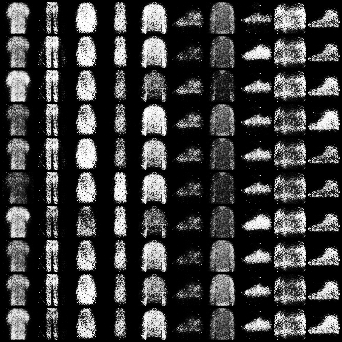

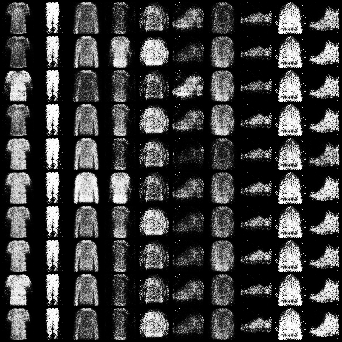

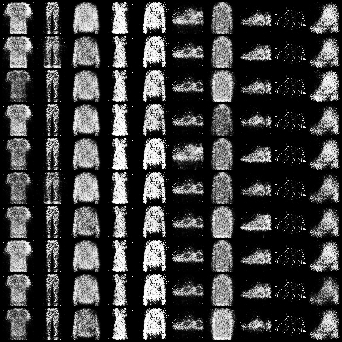

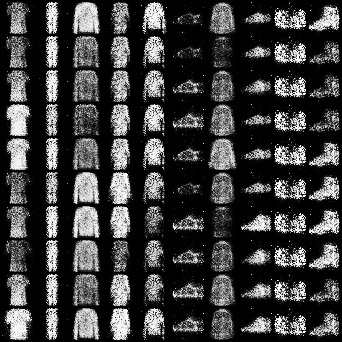

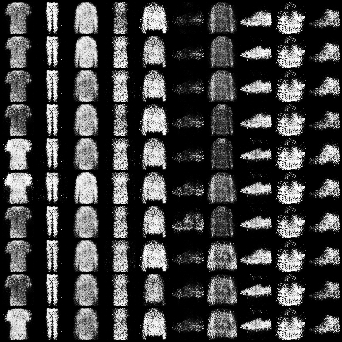

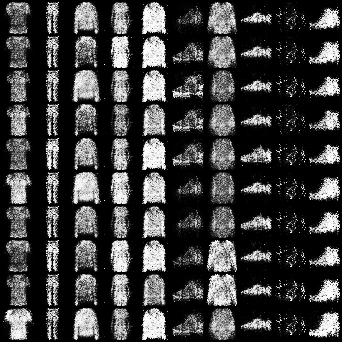

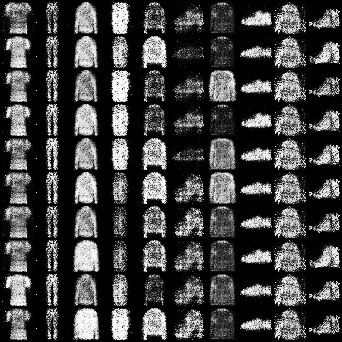

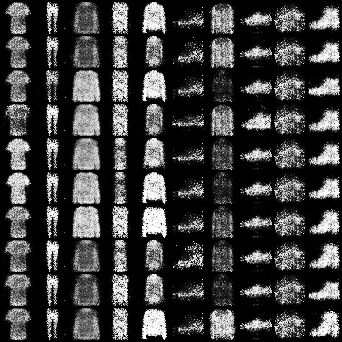

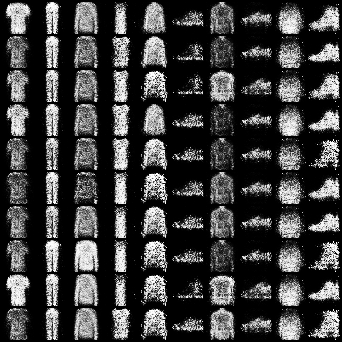

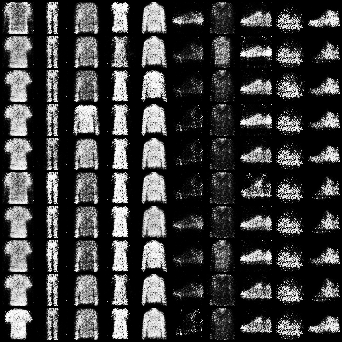

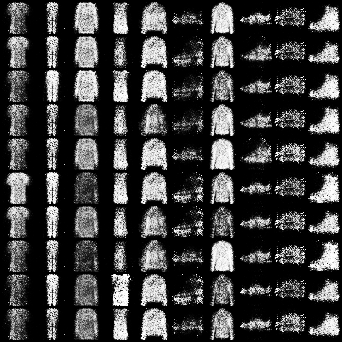

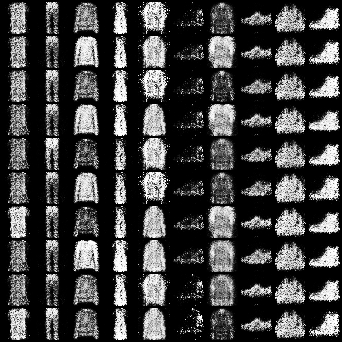

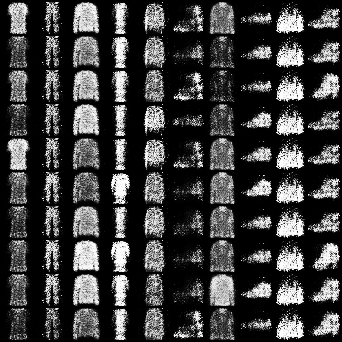

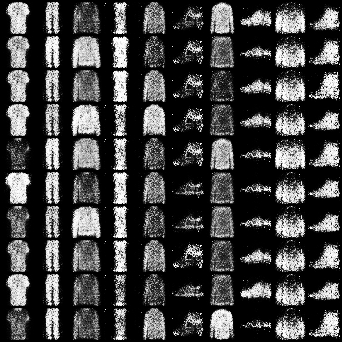

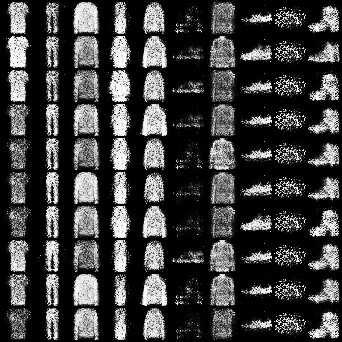

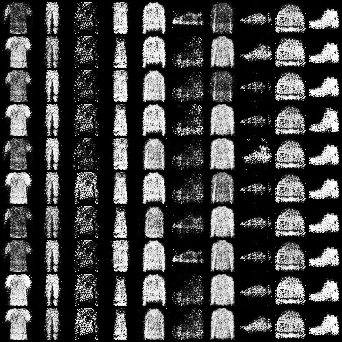

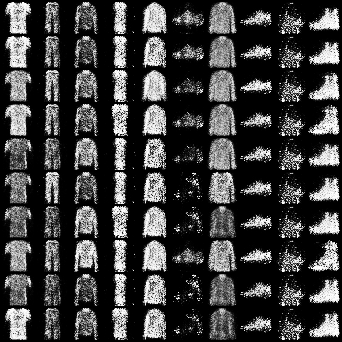

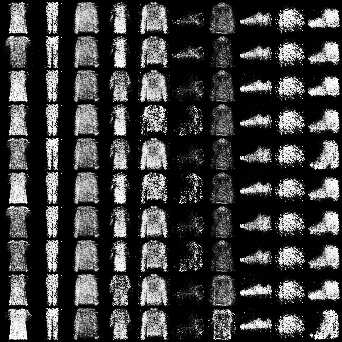

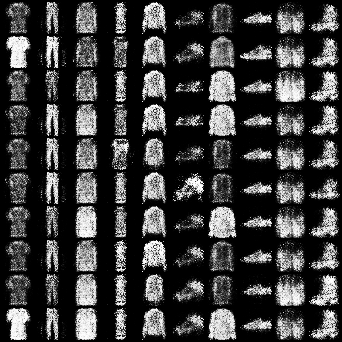

In [19]:
from PIL import Image
from IPython.display import Image 
import re
import glob

frames=[]
imgs = glob.glob("/content/images/*.png")
imgs.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
for i in imgs:
  pil_img = Image(filename=i)
  display(pil_img)
